<a href="https://colab.research.google.com/github/ersilia-os/event-fund-ai-drug-discovery/blob/main/notebooks/session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2: 
In this session, we will use a simple dataset to train a basic Machine Learning Model and understand the steps involved in their development.

*Disclaimer: this pipeline is an example prepared with curated data and should not be reproduced with the student's own datasets. The goal of this workshop is purely academic and does not represent a real research case study.*

## 1. Data Preparation

We will model a critical step in the drug discovery development, cardiotoxicty due to hERG blockade. hERG is a potassium channel whose blockage causes prolongued QT intervals and eventually cardiotoxicity, and is one of the major adverse drug reactions that cause compound attrition in the drug discovery pipelines. Therefore, it is essential to identify putative hERG blockers early on the drug discovery cascade.

Thanks to the Therapeutic Data Commons (TDC) we have adataset of molecules with its experimental hERG blocking activity that we can use to generate an ML model.

In [ ]:
# Install TDC in Google Colab

!pip install PyTDC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.2 MB/s 
     |████████████████████████████████| 36.8 MB 1.4 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.7-py3-none-any.whl size=130431 sha256=5875dd2047d56512454a1e65e5df9b79434b0ec721381c7dbf0d637cc11cd5bf
  Stored in directory: /root/.cache/pip/wheels/b1/57/8c/6ba602de7712931152522d89857f2a8c83e6925700cfa28144
Successfully built PyTDC


In [ ]:
# import the hERG dataset
from tdc.single_pred import Tox
data = Tox(name = "hERG")

Downloading...
100%|██████████| 50.2k/50.2k [00:00<00:00, 1.93MiB/s]
Loading...
Done!


In [ ]:
data #the dataset is packed, and we need to unpack and prepare it for ML modelling

### 1.1 Data Splits
We will start by splitting the data in 3 parts:

*   Train: the portion of the dataset that will be used to train the model
*   Valid: the validation set, which will be used during the modelling to assert and improve the performance of the algorithm
*   Test: a portion of the dataset kept completely separated from the data used to train the model. We will use this to evaluate the final model performance.

Usually, this process is done manually and must ensure that the three datasets are balanced (i.e. have an equal representation of positives and negatives and are representative of all the chemical space). 

For the purpose of the course, we will use the prepared TDC split which already guarantees the above conditions.


In [ ]:
split = data.get_split()
split.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
#we can now separate the compressed dataset in the three sections
train = split["train"]
valid = split["valid"]
test = split["test"]

In [ ]:
#we can check how many molecules we have in each set
print(len(train))
print(len(valid))
print(len(test))

458
66
131


In [ ]:
#let's explore the data
#by convention, the input (molecules in this case) is named X, and the output (bioactivity) is Y
train.head() 

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
3,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0
4,VANOXERINE HYDROCHLORIDE,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1,1.0


In [ ]:
#we can check the number of positives and negatives in the train set
print(len(train[train["Y"]==0])) #not cardiotoxic
print(len(train[train["Y"]==1])) # cardiotoxic

148
310


### 1.2 Data Visualization
Finally, before moving onto model training, we can leverage the Python Package RdKit, the largest open source toolbox for chemioinformatics, to explore a bit more the chemical structures of our data

In [ ]:
#we first need to install rdkit in Google Colab and import the packages of interest
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.4 MB/s 


In [ ]:
#we select a list of smiles

smiles = train["Drug"][449:] # from the 449 to the end of the dataset
smiles

449    CC1=C(CC(=O)[O-])c2cc(F)ccc2/C1=C\c1ccc(S(C)=O...
450            CNS(=O)(=O)Cc1ccc2c(c1)C(CC[NH+](C)C)C=N2
451                   C[N+]1=NN=C2C(C(N)=O)=NC=[N+]2C1=O
452                    CC(C)(C)[NH2+]CC(O)c1cc(O)cc(O)c1
453             CC12CCC3C(CCC4=CC(=O)C=CC43C)C1CCC(=O)O2
454                  O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1
455       O=P([O-])([O-])C(Sc1ccc(Cl)cc1)P(=O)([O-])[O-]
456                         Clc1ccc2nsnc2c1NC1=[NH+]CCN1
457      Cc1ccc(C(=O)c2cc(O)c([O-])c([N+](=O)[O-])c2)cc1
Name: Drug, dtype: object

In [ ]:
#convert the smiles to RdKit Molecules (not readable by humans)
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
mols

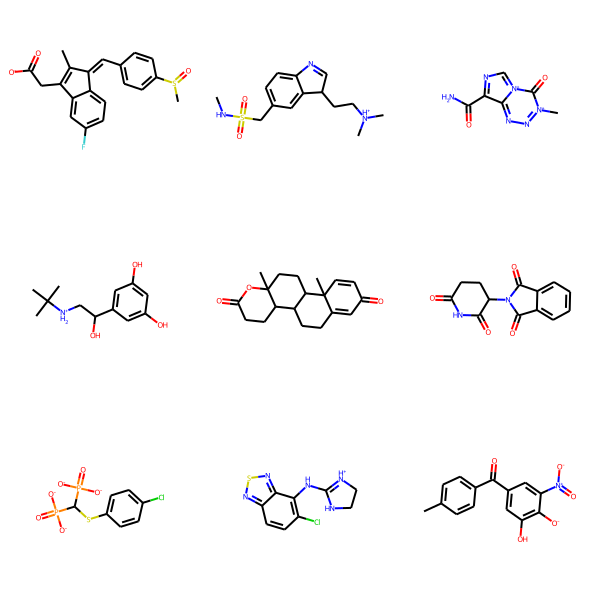

In [ ]:
#use the Draw function to visualise the molecules
Draw.MolsToGridImage(mols)

## 2. Molecule Featurization

To train an ML model, we need to be able to pass the molecules to the computer in a format that the computer can understand. That is, numerical vectors or images.

In this case, we will use the Chemical Checker to create signatures encompassing not only structural characteristics but also the bioactivity profile of the molecules.

In [ ]:
#first, we install the signaturizer and import it
!pip install signaturizer
from signaturizer import Signaturizer

sign = Signaturizer("GLOBAL")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for signaturizer: filename=signaturizer-1.1.13-py3-none-any.whl size=15084 sha256=08ee3e2a2f6e2c537a69a023ff5d604fa6cad2de6674d9364c834420cffbbaf2
  Stored in directory: /root/.cache/pip/wheels/88/56/35/966fc5275491313a2a0f37674624886e9ad38de6f6e2b19157
Successfully built signaturizer


In [ ]:
#we then convert the smiles (X)
X_train = sign.predict(train["Drug"]).signature

Parsing SMILES: 458it [00:00, 4865.56it/s]
Generating signatures: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


In [ ]:
# we can see how a molecule in the train set has been converted to a vector
X_train[0] #0 indicates the first molecule in the list

array([-0.09308645,  0.09305048, -0.09294817, ..., -0.05613168,
       -0.1379203 ,  0.05799835], dtype=float32)

In [ ]:
#we also convert the Validation and Test sets
X_valid = sign.predict(valid["Drug"]).signature
X_test = sign.predict(test["Drug"]).signature

Parsing SMILES: 66it [00:00, 5936.23it/s]
Generating signatures: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
Parsing SMILES: 131it [00:00, 6892.81it/s]
Generating signatures: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


In [ ]:
#finally, we need to prepare the outputs (Y), creating three lists:
Y_train = list(train["Y"])
Y_valid = list(valid["Y"])
Y_test = list(test["Y"])

## 3. Supervised Machine Learning

We will use the SciKit-Learn Python package to train an ML model based on a Random Forest algorithm. In this case, since the data is already binarized (0 and 1 for inactive and active, instead of continuous experimental results like IC50) we will train a Classifier.

In [ ]:
#install scikit-learn (sklearn) and import the RandomForest function

!pip install sklearn
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=1a9d2d2563dad0d7dcb596a9adb09595e9ddc9dc350254b5d851ae939c062e98
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
#in ML, the training of a model is called "fitting" the model to the data (the molecules and outputs of the Train set)

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier()

### 3.1 Model Evaluation
To understand whether a model is performing correctly or not, we have several measures. Here, we will use two of them:


*   Confusion matrices: a table that indicates how many molecules were correctly classified by the model and how many were misclassified.
*   ROC Curve: a probability curve showing the True Positive and False Positive Rates at different classification thresholds.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


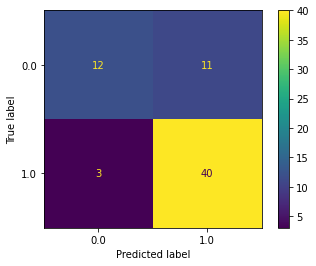

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_valid, Y_valid) #we use the validation set to check model performance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


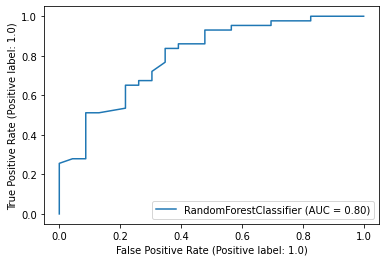

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_valid, Y_valid) #we use the validation set to check model performance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


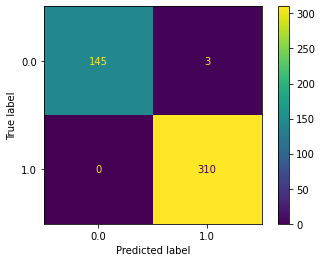

In [ ]:
#we can also try to predict the values in the training set and see how good our algorithm does:
plot_confusion_matrix(clf, X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


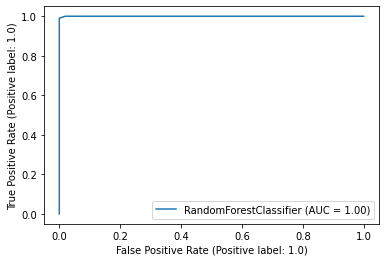

In [ ]:
plot_roc_curve(clf, X_train, Y_train)

### 3.2 Model Overfitting